In [82]:
#Importing libraries
import pandas as pd
from nltk.corpus import sentiwordnet as swn

In [9]:
#Read in word list
word_list = pd.read_csv('word_list.txt')

In [469]:
#Save as csv
df = pd.read_csv('all_training_final.csv')
df.head()

,text,label,source
0,The only thing I got from college was a caffei...,1,val
1,"""My (extended) fam was discussing going on a t...",1,val
2,i love shoegaze sm 😁,1,val
3,men are so grimey 😢,1,val
4,okay but like the say so song aint that bad. I...,1,val


In [472]:
df.shape

(79384, 3)

In [474]:
# Check for duplicates in 'Column1'
duplicates = df['text'].duplicated()

# Print rows with duplicates
len(df[duplicates])

10451

In [475]:
# Drop duplicate rows in 'Column1'
df = df.drop_duplicates(subset='text')
df.shape

(68933, 3)

In [445]:
#Importing libraries
import re, os, itertools, string
from collections import Counter
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import words
import numpy as np
import emoji
import utils
import time, os, utils
from sklearn.model_selection import train_test_split
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem.wordnet import WordNetLemmatizer

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\niamh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [476]:
#Functions used in initial preprocessing steps

#Define a function to remove URLs
def remove_urls(text):
    return re.sub(r'http\S+', '', text)

#Define a function to split hashtags within text
def split_hashtags_in_text(text):
    def split_hashtag(hashtag):
        split_words = []
        if hashtag != hashtag.lower() and hashtag != hashtag.upper():
            split_words = camel_case_split(hashtag)
        else:
            j = 0
            while j <= len(hashtag):
                loc = j
                for i in range(j + 1, len(hashtag) + 1, 1):
                    if hashtag[j:i].lower() in word_list:
                        loc = i
                if loc == j:
                    j += 1
                else:
                    split_words.append(hashtag[j:loc])
                    j = loc
        split_words = ['#' + str(s) for s in split_words]
        return split_words

    def camel_case_split(term):
        term = re.sub(r'([0-9]+)', r' \1', term)
        term = re.sub(r'(1st|2nd|3rd|4th|5th|6th|7th|8th|9th|0th)', r'\1 ', term)
        splits = re.finditer('.+?(?:(?<=[a-z])(?=[A-Z])|(?<=[A-Z])(?=[A-Z][a-z])|$)', term)
        return [s.group(0) for s in splits]

    #Find hashtags within the text using regex
    hashtags = re.findall(r'#\w+', text)
    
    #Split and flatten the hashtags
    split_hashtags = [split_hashtag(tag) for tag in hashtags]
    split_hashtags = [item for sublist in split_hashtags for item in sublist]
    
    #Replace the original hashtags in the text with the split words
    for hashtag in hashtags:
        text = text.replace(hashtag, ' '.join(split_hashtag(hashtag)))
    return text

#Define function to replace emoticons with emojis
def replace_emoticons(text, emoticons_to_emojis_dict):
    #Iterate through the dictionary and replace each emoticon with its corresponding emoji
    for emoticon, emoji in emoticons_to_emojis_dict.items():
        text = text.replace(emoticon, emoji)
    return text

In [477]:
def add_spaces_between_emojis(text):
    emoji_pattern = r'[\U0001F000-\U0001F6FF\U0001F900-\U0001F9FF\U00002600-\U000026FF\U00002700-\U000027BF\U0001F680-\U0001F6FF]'
    #Find all emojis in the text
    emojis = re.findall(emoji_pattern, text)
    #Iterate through found emojis and add spaces around each one
    for emoji in emojis:
        text = text.replace(emoji, f' {emoji} ')
    return text

#Apply the function 
for index, row in df.iterrows():
    text = row['text']
    text_with_spaces = add_spaces_between_emojis(text)
    df.at[index, 'text'] = text_with_spaces
df.head()

,text,label,source
0,The only thing I got from college was a caffei...,1,val
1,"""My (extended) fam was discussing going on a t...",1,val
2,i love shoegaze sm 😁,1,val
3,men are so grimey 😢,1,val
4,okay but like the say so song aint that bad. I...,1,val


In [478]:
#Define functions so that some punctuation symbols that convey tone are retained in the df
def add_spaces_around_special_characters(text):
    #Define a regular expression pattern to match the specified characters
    pattern = r'[?]|(\.{3})|[!]'
    #Use re.sub to add spaces around the matched characters 
    spaced_text = re.sub(pattern, lambda match: ' ' + match.group(0) + ' ' if match.group(0) else ' ... ', text)
    return spaced_text
#Apply the function 
for index, row in df.iterrows():
    text = row['text']
    text_with_spaces = add_spaces_around_special_characters(text)
    df.at[index, 'text'] = text_with_spaces
df.head()

,text,label,source
0,The only thing I got from college was a caffei...,1,val
1,"""My (extended) fam was discussing going on a t...",1,val
2,i love shoegaze sm 😁,1,val
3,men are so grimey 😢,1,val
4,okay but like the say so song aint that bad. I...,1,val


In [479]:
import re

def clean_text_dataframe(dataframe):
    # Convert 'text' column to strings
    dataframe['text'] = dataframe['text'].astype(str)
    print('Step 1 complete.')

    # Replace special characters with spaces
    dataframe['text'] = dataframe['text'].apply(lambda text: re.sub(r'([!*&%"~^+{}])', r' \1 ', text))
    print('Step 2 complete.')

    # Replace consecutive spaces with a single space
    dataframe['text'] = dataframe['text'].apply(lambda text: re.sub('\s{2,}', ' ', text))
    print('Step 3 complete.')

    # Iterate through each row and process the 'text' column
    for index, row in dataframe.iterrows():
        text = row['text']

        tokens = text.split()
        valid_tokens = [token for token in tokens if len(token) > 0]

        processed_text = ' '.join(valid_tokens)
        dataframe.at[index, 'text'] = processed_text
    print('Step 4 complete.')

    # Remove any hashtags relating to sarcasm
    dataframe['text'] = dataframe['text'].str.replace(r'\b\w*\.lower\(\)\.startswith\(\'#sarca\'\)\b', '', regex=True)
    print('Step 5 complete.')

    # Remove all URLs
    dataframe['text'] = dataframe['text'].apply(remove_urls)
    print('Step 6 complete.')

    # Replace user mentions with a generic @user
    dataframe['text'] = dataframe['text'].str.replace(r'@\w+', '@user', regex=True)
    print('Step 7 complete.')

    # Split hashtags into words
    dataframe['text'] = dataframe['text'].apply(split_hashtags_in_text)
    print('Step 8 complete.')

    # Make all words lowercase
    dataframe['text'] = dataframe['text'].str.lower()
    print('Step 9 complete.')

    return dataframe

# Test the function
df = clean_text_dataframe(df)
df.head()


Step 1 complete.
Step 2 complete.
Step 3 complete.
Step 4 complete.
Step 5 complete.
Step 6 complete.
Step 7 complete.
Step 8 complete.
Step 9 complete.


,text,label,source
0,the only thing i got from college was a caffei...,1,val
1,""" my (extended) fam was discussing going on a ...",1,val
2,i love shoegaze sm 😁,1,val
3,men are so grimey 😢,1,val
4,okay but like the say so song aint that bad. i...,1,val


In [480]:
#Define a function to remove characters missed before
def remove_special_characters(text):
    #Define a regular expression pattern to match the specified characters
    pattern = r'["\/\\().,:]'
    #Use re.sub to replace the matched characters with a space
    cleaned_text = re.sub(pattern, ' ', text)
    return cleaned_text

#Apply the function
for index, row in df.iterrows():
    text = row['text']
    text_with_removed_characters = remove_special_characters(text)
    df.at[index, 'text'] = text_with_removed_characters
df.head()

,text,label,source
0,the only thing i got from college was a caffei...,1,val
1,my extended fam was discussing going on a ...,1,val
2,i love shoegaze sm 😁,1,val
3,men are so grimey 😢,1,val
4,okay but like the say so song aint that bad i...,1,val


In [484]:
#Get stopwords
stopwords = set(stopwords.words('english'))

#Define function to remove stopwords from the text
def remove_stopwords(text):
    #Tokenize the text into words
    words = text.split()
    #Filter out stopwords
    words = [word for word in words if word.lower() not in stopwords]
    #Join the remaining words back into a string
    return ' '.join(words)

#Get lemmatiser
lemmatizer = WordNetLemmatizer()

#Define function to lemmatise the text
def lemmatize_text(text):
    lemmatized_tokens = []
    for token in text.split():
        token = token.lower()
        #Attempt lemmatization as a verb first
        lemmatized_token = lemmatizer.lemmatize(token, 'v')
        #If verb lemmatization doesn't work, try general lemmatization
        lemmatized_token = lemmatizer.lemmatize(lemmatized_token)
        lemmatized_tokens.append(lemmatized_token)
    return ' '.join(lemmatized_tokens)

#Define a function to apply these processing steps in a sequence
def clean_stopwords_lemmatize(dataframe):
    for index, row in dataframe.iterrows():
        dataframe.at[index, 'text'] = remove_stopwords(row['text'])
    print('Step 1 Complete.')
    
    for index, row in dataframe.iterrows():
        dataframe.at[index, 'text'] = lemmatize_text(row['text'])
        print('Step 2 Complete.')
        return dataframe
    
#Apply the function to the overall df
df_clean_a = clean_stopwords_lemmatize(df)
df_clean_a.head()

Step 1 Complete.
Step 2 Complete.


,text,label,source
0,thing get college caffeine addiction 😏,1,val
1,extended fam discussing going trip instead get...,1,val
2,love shoegaze sm 😁,1,val
3,men grimey 😢,1,val
4,okay like say song aint bad im unironically ja...,1,val


In [485]:
df_a_emoji = df_clean_a.copy()

In [486]:
#Importing libraries
from gensim.models import KeyedVectors
import gensim.downloader as api
from keras.preprocessing.text import Tokenizer
from numpy import zeros

In [487]:
#Create lists for emojis and vectors
emoji_list = []
vector_list = []

#Extract contents into lists
with open('emoji2vec.txt', 'r', encoding='utf-8') as file:
    for idx, line in enumerate(file):
        if idx == 0:
            continue 
        tokens = line.strip().split()
        emoji = tokens[0]
        vector = [float(v) for v in tokens[1:]]
        emoji_list.append(emoji)
        vector_list.append(vector)

#Confirm contents is all there
len(emoji_list), len(vector_list)

(1661, 1661)

In [455]:
#Create a dictionary to store the emoji vectors mapping
emoji_vectors = {}
for emoji, vector in zip(emoji_list, vector_list):
    #if len(vector) == vector_size:
        emoji_vectors[emoji] = vector

In [30]:
#Download the pre-trained Word2Vec model from Gensim data server (300d to match emoji vector)
word2vec_model = api.load('word2vec-google-news-300')

#Initialize an empty dictionary to store word vectors
word_vectors = {}

#Iterate through words in your vocabulary
for word in vocabulary:
    #Check if the word exists in the Word2Vec model
    if word in word2vec_model:
        #Get the word vector
        word_vector = word2vec_model[word]
        #Store the word vector in the dictionary
        word_vectors[word] = word_vector

In [457]:
#Combine the two dictionaries
all_vectors = {}

#Update the combined dictionary with emoji vectors then the word vectors
all_vectors.update(emoji_vectors)
all_vectors.update(word_vectors)

In [488]:
#Check how many vectors there are
len(all_vectors)

26681

In [489]:
#Define a function to build a vocabulary which accounts for word frequency
def build_vocabulary(dataframe):
    vocabulary = Counter()
    #Iterate through rows and split words out
    for index, row in dataframe.iterrows():
        text = row['text'] 
        vocabulary.update([word.lower() for word in text.split()])
    #Sort the vocabulary by word frequency
    vocabulary = sorted(vocabulary.items(), key=lambda pair: pair[1], reverse=False)
    #Create an indexed vocabulary with unique numerical indices
    counter = 1
    indexed_vocabulary = {}
    for (key, _) in vocabulary:
        indexed_vocabulary[key] = counter
        counter += 1
    #Add an token to handle OOV words
    indexed_vocabulary['unk'] = len(indexed_vocabulary) + 1
    print("Built vocabulary of size ", len(indexed_vocabulary))
    return indexed_vocabulary

In [490]:
#Get the vocabulary
vocabulary = build_vocabulary(df_a_emoji)

Built vocabulary of size  43658


In [509]:
#Create a tokenizer
tokenizer = Tokenizer()
#Fit the tokenizer to df
tokenizer.fit_on_texts(df_a_emoji["text"])

In [492]:
#Initialize an empty dictionary to store word vectors
word_vectors = {}

#Iterate through words in your vocabulary
for word in vocabulary:
    #Check if the word exists in the Word2Vec model
    if word in word2vec_model:
        #Get the word vector
        word_vector = word2vec_model[word]
        #Store the word vector in the dictionary
        word_vectors[word] = word_vector
        
print(len(word_vectors))

25020


In [502]:
#Add in emoji vectors
all_vectors = {}

#Update the combined dictionary with emoji vectors then the word vectors
all_vectors.update(emoji_vectors)
all_vectors.update(word_vectors)

print(len(all_vectors))

26681


In [503]:
#Calculate vocab length
vocab_length = len(tokenizer.word_index) + 1

In [504]:
#Generate vocab from the word tokens
vocab = list(tokenizer.word_index.keys())

In [505]:
#Check this is correct
vocab

['user',
 'a',
 'love',
 "i'm",
 'like',
 'day',
 'get',
 'people',
 'good',
 'great',
 'one',
 'time',
 'really',
 '😂',
 'u',
 'much',
 'know',
 'speak',
 'go',
 "can't",
 'life',
 'today',
 'see',
 'back',
 'want',
 'best',
 'need',
 'happy',
 'going',
 'work',
 'would',
 'wait',
 'got',
 'think',
 'school',
 'rt',
 'make',
 'never',
 'right',
 'hate',
 'always',
 '2',
 'night',
 'new',
 '️',
 'thanks',
 'say',
 'someone',
 'fun',
 "that's",
 'shit',
 'thank',
 'even',
 'first',
 'way',
 'well',
 'sleep',
 'better',
 'still',
 '3',
 'ever',
 '😊',
 'home',
 'getting',
 'could',
 'lol',
 'last',
 'yay',
 'feel',
 'oh',
 'thing',
 'look',
 'morning',
 'us',
 'nice',
 'come',
 'take',
 'im',
 '❤',
 'tomorrow',
 'awesome',
 'man',
 'please',
 "i've",
 '😍',
 'year',
 'something',
 'friends',
 'things',
 'class',
 '1',
 'next',
 'start',
 'tonight',
 'gonna',
 'hope',
 'every',
 'week',
 'made',
 'yeah',
 'world',
 'long',
 'game',
 'birthday',
 '5',
 "'",
 '4',
 'looking',
 'excited',
 'pe

In [578]:
#Create numpy array embedding matrix - start empty with a dimensionality of 300 corresponding to the vectors
embedding_matrix = zeros((vocab_length, 300))

#For each word in the vocab, check if it is present in the embeddings_dictionary
for index, word in enumerate(vocab):
    if index < vocab_length: 
        embedding_vector = all_vectors.get(word)
        #If it is there, the vector is added to the correct row in the embedding matrix - otherwise, it will just remain zeros
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector
            
print('Matrix:')
print(embedding_matrix[2]) 

Matrix:
[ 0.10302734 -0.15234375  0.02587891  0.16503906 -0.16503906  0.06689453
  0.29296875 -0.26367188 -0.140625    0.20117188 -0.02624512 -0.08203125
 -0.02770996 -0.04394531 -0.23535156  0.16992188  0.12890625  0.15722656
  0.00756836 -0.06982422 -0.03857422  0.07958984  0.22949219 -0.14355469
  0.16796875 -0.03515625  0.05517578  0.10693359  0.11181641 -0.16308594
 -0.11181641  0.13964844  0.01556396  0.12792969  0.15429688  0.07714844
  0.26171875  0.08642578 -0.02514648  0.33398438  0.18652344 -0.20996094
  0.07080078  0.02600098 -0.10644531 -0.10253906  0.12304688  0.04711914
  0.02209473  0.05834961 -0.10986328  0.14941406 -0.10693359  0.01556396
  0.08984375  0.11230469 -0.04370117 -0.11376953 -0.0037384  -0.01818848
  0.24316406  0.08447266 -0.07080078  0.18066406  0.03515625 -0.09667969
 -0.21972656 -0.00328064 -0.03198242  0.18457031  0.28515625 -0.0859375
 -0.11181641  0.0213623  -0.30664062 -0.09228516 -0.18945312  0.01513672
  0.18554688  0.34375    -0.31054688  0.2255

In [498]:
#Check shape
df_a_emoji.shape

(68933, 3)

In [499]:
#Check for null values
df_a_emoji.isnull().sum()

text      0
label     0
source    0
dtype: int64

In [500]:
#Check for duplicates 
df_a_emoji.duplicated(subset=["text"]).sum()

8864

In [501]:
# Check for duplicates
duplicate_count = df_a_emoji.duplicated(subset=["text"]).sum()

# Drop duplicates based on the "text" column
df_a_emoji.drop_duplicates(subset=["text"], inplace=True)

# Print the number of duplicates removed
print(f"Dropped {duplicate_count} duplicates.")


Dropped 8864 duplicates.


In [506]:
#Tokenize the text
df_a_emoji["text"] = df_a_emoji["text"].apply(lambda x: word_tokenize(x))
df_a_emoji.head()

,text,label,source
0,"[thing, get, college, caffeine, addiction, 😏]",1,val
1,"[extended, fam, discussing, going, trip, inste...",1,val
2,"[love, shoegaze, sm, 😁]",1,val
3,"[men, grimey, 😢]",1,val
4,"[okay, like, say, song, aint, bad, im, unironi...",1,val


In [507]:
from nltk.tokenize import word_tokenize

In [508]:
#Check there are no rows with no tokens- remove if there are

#Count the tokens per row and find rows with zero tokens
zero_tokens = df_a_emoji['text'].apply(len) == 0

#Filter to find any rows with no tokens
rows_with_zero_tokens = df_a_emoji[zero_tokens]

# Check if there are any rows with zero tokens
if len(rows_with_zero_tokens) > 0:
    print("Rows with zero tokens:")
    print(rows_with_zero_tokens)
else:
    print("No rows with zero tokens found.")

Rows with zero tokens:
     text  label source
1544   []      0    val


In [ ]:
#Drop rows with zero tokens
df_a_emoji = df_a_emoji[~zero_tokens]
df_a_emoji = df_a_emoji.reset_index(drop=True)
df_a_emoji.shape

In [511]:
#Define the maximum allowed sequence length
max_sequence_length = 38

#Create a boolean mask for rows with text length exceeding the maximum
mask = df_a_emoji['text'].apply(lambda x: len(x)) <= max_sequence_length

#Filter the df to keep only rows that meet the condition
df_filtered = df_a_emoji[mask]

#Reset index
df_a_emoji.reset_index(drop=True, inplace=True)
#Check df
df_a_emoji.head()

,text,label,source
0,"[thing, get, college, caffeine, addiction, 😏]",1,val
1,"[extended, fam, discussing, going, trip, inste...",1,val
2,"[love, shoegaze, sm, 😁]",1,val
3,"[men, grimey, 😢]",1,val
4,"[okay, like, say, song, aint, bad, im, unironi...",1,val


In [512]:
#Tokenise text to numeric form for NN

#Create a tokenizer
tokenizer = Tokenizer(num_words=vocab_length, oov_token="<OOV>")
tokenizer.fit_on_texts(df_a_emoji['text'])

#Convert text to sequences of integers
sequences = tokenizer.texts_to_sequences(df_a_emoji['text'])

#Check one example
sequences[0]

[85, 15, 351, 5459, 2936, 574]

In [513]:
#Set the maximum sequence length
max_sequence_length = 38

#Iterate through the rows and pad the text data to the max length
for index, sequence in enumerate(sequences):
    if len(sequence) < max_sequence_length:
        #Pad the sequence with zeros at the end
        padded_sequence = sequence + [0] * (max_sequence_length - len(sequence))
    else:
        #Truncate the sequence if it's longer than the maximum length
        padded_sequence = sequence[:max_sequence_length]

    #Update the text column with the padded sequence
    df_a_emoji.at[index, 'text'] = padded_sequence
    
#Check the df
df_a_emoji.head()

,text,label,source
0,"[85, 15, 351, 5459, 2936, 574, 0, 0, 0, 0, 0, ...",1,val
1,"[4243, 1442, 3667, 39, 949, 411, 79, 4015, 484...",1,val
2,"[7, 18643, 4735, 380, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,val
3,"[390, 18644, 1060, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,val
4,"[316, 11, 65, 227, 1779, 150, 92, 9073, 3142, ...",1,val


In [321]:
# Define feature and label columns
X = df_a_emoji['text']
y = df_a_emoji['label']

# Split data into test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert training data and labels to numpy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

# Check the data shape (optional)
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
# Check the data shape (optional)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (48054,)
y_train shape: (48054,)
X_test shape: (12014,)
y_test shape: (12014,)


In [323]:
# Define the maximum sequence length you want to use
maxlen = 38  # Adjust this value as needed

# Initialize an empty list to store the padded sequences
X_train_padded = []

# Iterate through the tokenized sequences and pad each one
for sequence in X_train:
    # Check the length of the sequence
    if len(sequence) < maxlen:
        # If it's shorter than maxlen, pad it with zeros at the end (not the beginning)
        padded_sequence = sequence + [0] * (maxlen - len(sequence))
    else:
        # If it's longer than maxlen, truncate it to maxlen
        padded_sequence = sequence[:maxlen]
    
    # Add the padded sequence to the list
    X_train_padded.append(padded_sequence)

# Convert the list of lists to a NumPy array
X_train_padded = np.array(X_train_padded)

# Now X_train_padded is a NumPy array of shape (number_of_samples, maxlen)
# Check the data shape (optional)
print("X_train shape:", X_train_padded.shape)
print("y_train shape:", y_train.shape)
# Check the data shape (optional)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)
print(X_train_padded[10])

X_train shape: (48054, 38)
y_train shape: (48054,)
X_test shape: (12014,)
y_test shape: (12014,)
[ 990  192  767  201  187 6358 1913   31  800    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0]


In [324]:
# Define the maximum sequence length you want to use
maxlen = 38  # Adjust this value as needed

# Initialize an empty list to store the padded sequences
X_test_padded = []

# Iterate through the tokenized sequences and pad each one
for sequence in X_test:
    # Check the length of the sequence
    if len(sequence) < maxlen:
        # If it's shorter than maxlen, pad it with zeros at the end (not the beginning)
        padded_sequence = sequence + [0] * (maxlen - len(sequence))
    else:
        # If it's longer than maxlen, truncate it to maxlen
        padded_sequence = sequence[:maxlen]
    
    # Add the padded sequence to the list
    X_test_padded.append(padded_sequence)

# Convert the list of lists to a NumPy array
X_test_padded = np.array(X_test_padded)

# Check the data shape (optional)
print("X_train shape:", X_train_padded.shape)
print("y_train shape:", y_train.shape)
# Check the data shape (optional)
print("X_test shape:", X_test_padded.shape)
print("y_test shape:", y_test.shape)
print(X_train_padded[10])

X_train shape: (48054, 38)
y_train shape: (48054,)
X_test shape: (12014, 38)
y_test shape: (12014,)
[ 990  192  767  201  187 6358 1913   31  800    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0]


# Create sentiment embedding

In [379]:
#Importing libraries
import collections
import matplotlib.pyplot as plt

In [515]:
#Check vocab 
vocab

['user',
 'a',
 'love',
 "i'm",
 'like',
 'day',
 'get',
 'people',
 'good',
 'great',
 'one',
 'time',
 'really',
 '😂',
 'u',
 'much',
 'know',
 'speak',
 'go',
 "can't",
 'life',
 'today',
 'see',
 'back',
 'want',
 'best',
 'need',
 'happy',
 'going',
 'work',
 'would',
 'wait',
 'got',
 'think',
 'school',
 'rt',
 'make',
 'never',
 'right',
 'hate',
 'always',
 '2',
 'night',
 'new',
 '️',
 'thanks',
 'say',
 'someone',
 'fun',
 "that's",
 'shit',
 'thank',
 'even',
 'first',
 'way',
 'well',
 'sleep',
 'better',
 'still',
 '3',
 'ever',
 '😊',
 'home',
 'getting',
 'could',
 'lol',
 'last',
 'yay',
 'feel',
 'oh',
 'thing',
 'look',
 'morning',
 'us',
 'nice',
 'come',
 'take',
 'im',
 '❤',
 'tomorrow',
 'awesome',
 'man',
 'please',
 "i've",
 '😍',
 'year',
 'something',
 'friends',
 'things',
 'class',
 '1',
 'next',
 'start',
 'tonight',
 'gonna',
 'hope',
 'every',
 'week',
 'made',
 'yeah',
 'world',
 'long',
 'game',
 'birthday',
 '5',
 "'",
 '4',
 'looking',
 'excited',
 'pe

In [384]:
#Make the list a df
df_vocab = pd.DataFrame(vocab, columns=["word"])
df_vocab.head()

,word
0,user
1,a
2,love
3,like
4,i'm


In [385]:
# Function to calculate positivity score for a word
def calculate_positivity_score(word):
    # Initialize positivity score to 0.0
    pos_score = 0.0
    
    # Use SentiWordNet to get the positivity score
    synsets = list(swn.senti_synsets(word))
    
    # Calculate the average positivity score if synsets are found
    if synsets:
        pos_scores = [synset.pos_score() for synset in synsets]
        pos_score = sum(pos_scores) / len(synsets)
    
    return pos_score

# Apply the function to each row in the DataFrame and create a new column
df_vocab["pos_score"] = df_vocab["word"].apply(calculate_positivity_score)

# Display the DataFrame with the positivity scores
df_vocab.head()

,word,pos_score
0,user,0.000000
1,a,0.017857
2,love,0.387500
3,like,0.284091
4,i'm,0.000000


In [386]:
# Function to calculate negativity score for a word
def calculate_neg_score(word):
    # Initialize negativity score to 0.0
    neg_score = 0.0
    
    # Use SentiWordNet to get the negativity score
    synsets = list(swn.senti_synsets(word))
    
    # Calculate the average negativity score if synsets are found
    if synsets:
        neg_scores = [synset.neg_score() for synset in synsets]
        neg_score = sum(neg_scores) / len(synsets)
    
    return neg_score

# Apply the function to each row in the DataFrame and create a new column
df_vocab["neg_score"] = df_vocab["word"].apply(calculate_neg_score)

# Display the DataFrame with the positivity scores
df_vocab.head()

,word,pos_score,neg_score
0,user,0.000000,0.000000
1,a,0.017857,0.035714
2,love,0.387500,0.012500
3,like,0.284091,0.022727
4,i'm,0.000000,0.000000


In [410]:
import seaborn as sns

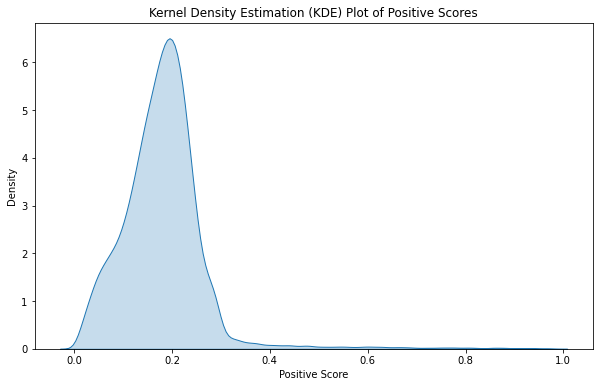

In [411]:
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df_vocab, x='pos_score', fill=True)
plt.xlabel('Positive Score')
plt.ylabel('Density')
plt.title('Kernel Density Estimation (KDE) Plot of Positive Scores')
plt.show()

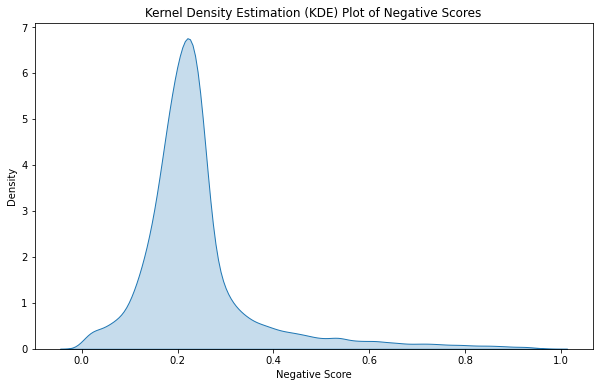

In [413]:
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df_vocab, x='neg_score', fill=True)
plt.xlabel('Negative Score')
plt.ylabel('Density')
plt.title('Kernel Density Estimation (KDE) Plot of Negative Scores')
plt.show()

In [85]:
emotion_info = pd.read_csv('emoji_emotion_stats_all.csv')
emotion_info.head()

,emoji,anger,joy,sadness,fear,surprise,disgust,anticipation,trust,pred_neg,pred_pos,pred_neut,pred_sent_score
0,🇸🇰,0.074503,0.084563,0.061850,0.068795,0.072184,0.063562,0.081030,0.083386,0.061693,0.154219,0.784088,0.092526
1,👔,0.073802,0.074975,0.074787,0.080874,0.072140,0.048375,0.080391,0.084093,0.316915,0.099384,0.583700,-0.217531
2,🌀,0.080796,0.087879,0.073162,0.076530,0.076504,0.071957,0.085254,0.080753,0.087130,0.409846,0.503024,0.322716
3,🚾,0.079520,0.087601,0.106218,0.100683,0.084863,0.054167,0.095245,0.110732,0.145850,0.254009,0.600141,0.108159
4,👹,0.064922,0.077376,0.070871,0.071265,0.070346,0.052338,0.078957,0.085835,0.185388,0.172381,0.642231,-0.013007


In [397]:
df_emoji = pd.DataFrame()
df_emoji['word'] = emotion_info['emoji']
df_emoji['pos_score'] = emotion_info['pred_pos']
df_emoji['neg_score'] = emotion_info['pred_neg']
df_emoji.head()

,word,pos_score,neg_score
0,🇸🇰,0.154219,0.061693
1,👔,0.099384,0.316915
2,🌀,0.409846,0.087130
3,🚾,0.254009,0.145850
4,👹,0.172381,0.185388


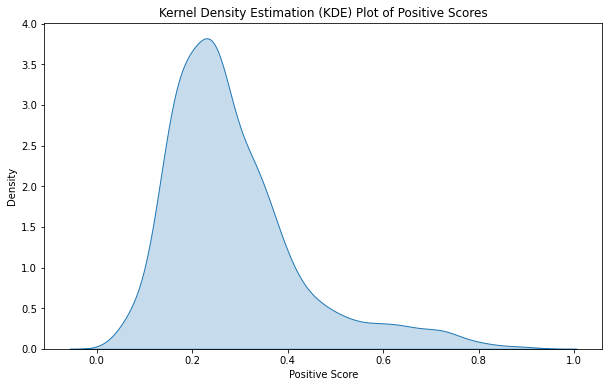

In [414]:
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df_emoji, x='pos_score', fill=True)
plt.xlabel('Positive Score')
plt.ylabel('Density')
plt.title('Kernel Density Estimation (KDE) Plot of Positive Scores')
plt.show()

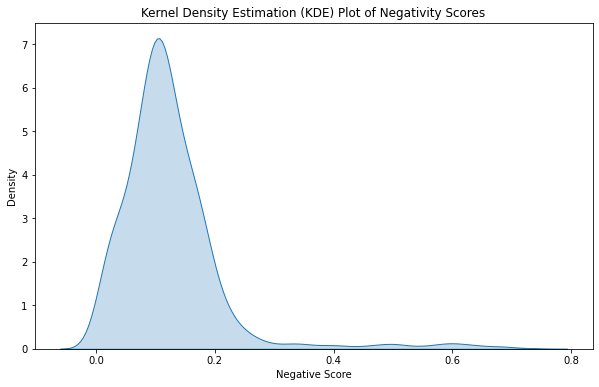

In [415]:
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df_emoji, x='neg_score', fill=True)
plt.xlabel('Negative Score')
plt.ylabel('Density')
plt.title('Kernel Density Estimation (KDE) Plot of Negativity Scores')
plt.show()

In [399]:
print(df_vocab.shape)
df_vocab = df_vocab[~df_vocab['word'].isin(df_emoji['word'])]
print(df_vocab.shape)

(38385, 3)
(37878, 3)


In [400]:
# Concatenate along rows (axis=0)
df_embedding = pd.concat([df_vocab, df_emoji], axis=0)
df_embedding.head()

,word,pos_score,neg_score
0,user,0.292249,0.230560
1,a,0.255146,0.242248
2,love,0.548703,0.085357
3,like,0.241746,0.199435
4,i'm,0.184428,0.229113


In [401]:
#Check for duplicates 
df_embedding.duplicated(subset=["word"]).sum()

0

In [402]:
df_embedding.shape

(39553, 3)

In [416]:
from sklearn.preprocessing import MinMaxScaler

In [420]:
# Create a Min-Max scaler
scaler = MinMaxScaler()

# Fit the scaler to your 'pos_score' column and transform it
df_vocab['scaled_pos_score'] = scaler.fit_transform(df_vocab['pos_score'].values.reshape(-1, 1))
df_vocab['scaled_neg_score'] = scaler.fit_transform(df_vocab['neg_score'].values.reshape(-1, 1))

In [417]:
# Create a Min-Max scaler
scaler = MinMaxScaler()

# Fit the scaler to your 'pos_score' column and transform it
df_emoji['scaled_pos_score'] = scaler.fit_transform(df_emoji['pos_score'].values.reshape(-1, 1))
df_emoji['scaled_neg_score'] = scaler.fit_transform(df_emoji['neg_score'].values.reshape(-1, 1))

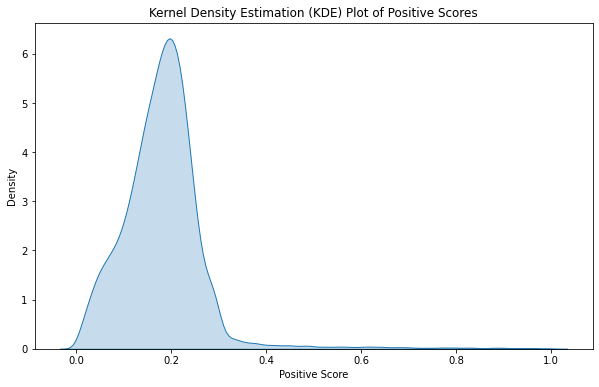

In [423]:
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df_vocab, x='scaled_pos_score', fill=True)
plt.xlabel('Positive Score')
plt.ylabel('Density')
plt.title('Kernel Density Estimation (KDE) Plot of Positive Scores')
plt.show()

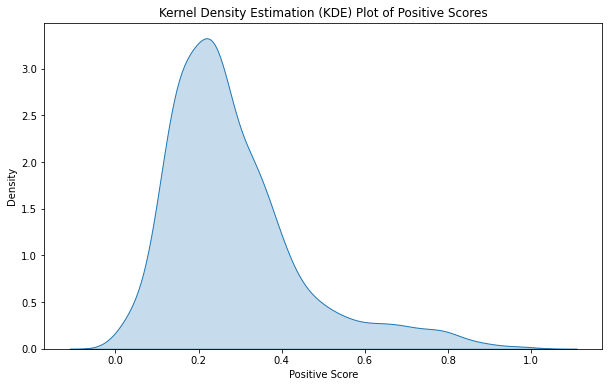

In [424]:
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df_emoji, x='scaled_pos_score', fill=True)
plt.xlabel('Positive Score')
plt.ylabel('Density')
plt.title('Kernel Density Estimation (KDE) Plot of Positive Scores')
plt.show()

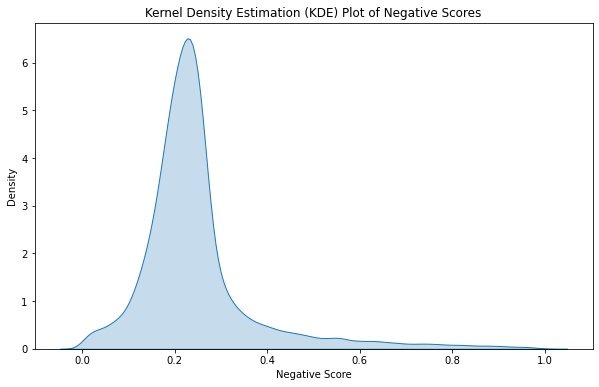

In [425]:
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df_vocab, x='scaled_neg_score', fill=True)
plt.xlabel('Negative Score')
plt.ylabel('Density')
plt.title('Kernel Density Estimation (KDE) Plot of Negative Scores')
plt.show()

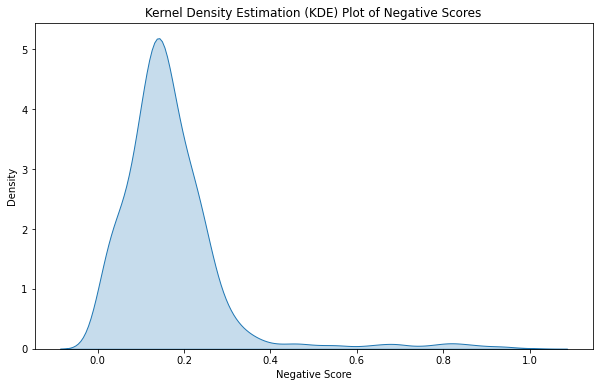

In [426]:
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df_emoji, x='scaled_neg_score', fill=True)
plt.xlabel('Negative Score')
plt.ylabel('Density')
plt.title('Kernel Density Estimation (KDE) Plot of Negative Scores')
plt.show()

In [427]:
# Concatenate along rows (axis=0)
df_embedding = pd.concat([df_vocab, df_emoji], axis=0)
df_embedding.head()

,word,pos_score,neg_score,scaled_pos_score,scaled_neg_score
0,user,0.292249,0.230560,0.297030,0.237535
1,a,0.255146,0.242248,0.258824,0.249660
2,love,0.548703,0.085357,0.561111,0.086891
3,like,0.241746,0.199435,0.245026,0.205244
4,i'm,0.184428,0.229113,0.186003,0.236033


In [516]:
#Convert text to sequences of integers
df_embedding['word_token'] = tokenizer.texts_to_sequences(df_embedding['word'])

#Check one example
df_embedding.head()

,word,pos_score,neg_score,scaled_pos_score,scaled_neg_score,word_token
0,user,0.292249,0.230560,0.297030,0.237535,[4]
1,a,0.255146,0.242248,0.258824,0.249660,[6]
2,love,0.548703,0.085357,0.561111,0.086891,[7]
3,like,0.241746,0.199435,0.245026,0.205244,[11]
4,i'm,0.184428,0.229113,0.186003,0.236033,[1]


In [522]:
#Convert text to sequences of integers
df_embedding['sent_score'] = df_embedding['scaled_pos_score'] - df_embedding['scaled_neg_score']

#Check one example
df_embedding.head()

,word,pos_score,neg_score,scaled_pos_score,scaled_neg_score,word_token,sent_score
0,user,0.292249,0.230560,0.297030,0.237535,[4],0.059495
1,a,0.255146,0.242248,0.258824,0.249660,[6],0.009164
2,love,0.548703,0.085357,0.561111,0.086891,[7],0.474220
3,like,0.241746,0.199435,0.245026,0.205244,[11],0.039782
4,i'm,0.184428,0.229113,0.186003,0.236033,[1],-0.050031


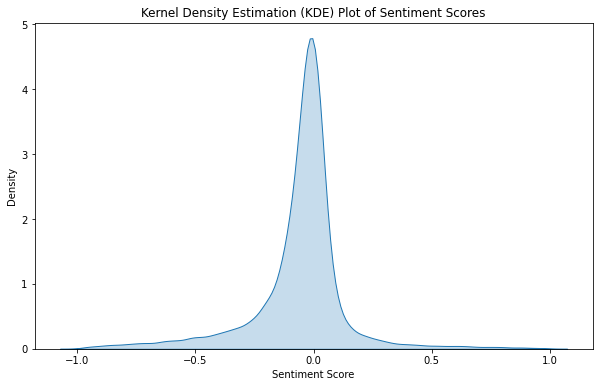

In [523]:
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df_embedding, x='sent_score', fill=True)
plt.xlabel('Sentiment Score')
plt.ylabel('Density')
plt.title('Kernel Density Estimation (KDE) Plot of Sentiment Scores')
plt.show()

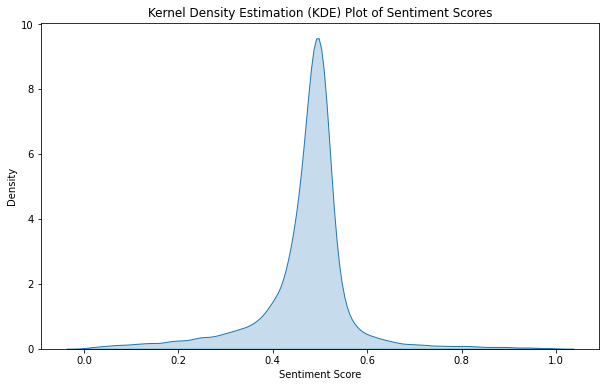

In [524]:
# Create a Min-Max scaler
scaler = MinMaxScaler()

# Fit the scaler to your 'pos_score' column and transform it
df_embedding['sent_score'] = scaler.fit_transform(df_embedding['sent_score'].values.reshape(-1, 1))

plt.figure(figsize=(10, 6))
sns.kdeplot(data=df_embedding, x='sent_score', fill=True)
plt.xlabel('Sentiment Score')
plt.ylabel('Density')
plt.title('Kernel Density Estimation (KDE) Plot of Sentiment Scores')
plt.show()

In [555]:
df_embedding.shape

(39553, 7)

In [905]:
# Initialize the MinMaxScaler
scaler = MinMaxScaler(feature_range=(1, 50))

# Fit and transform your column
df_embedding['int_pos'] = scaler.fit_transform(df_embedding[['scaled_pos_score']])

# Round the rescaled values to the nearest integer
df_embedding['int_pos'] = df_embedding['int_pos'].round().astype(int)
df_embedding.head()

,word,pos_score,neg_score,scaled_pos_score,scaled_neg_score,word_token,sent_score,int_pos
0,user,0.292249,0.230560,0.297030,0.237535,[4],0.529668,16
1,a,0.255146,0.242248,0.258824,0.249660,[6],0.504485,14
2,love,0.548703,0.085357,0.561111,0.086891,[7],0.737179,28
3,like,0.241746,0.199435,0.245026,0.205244,[11],0.519805,13
4,i'm,0.184428,0.229113,0.186003,0.236033,[1],0.474867,10


In [906]:
# Initialize the MinMaxScaler
scaler = MinMaxScaler(feature_range=(1, 50))

# Fit and transform your column
df_embedding['int_neg'] = scaler.fit_transform(df_embedding[['scaled_neg_score']])

# Round the rescaled values to the nearest integer
df_embedding['int_neg'] = df_embedding['int_neg'].round().astype(int)
df_embedding.head()

,word,pos_score,neg_score,scaled_pos_score,scaled_neg_score,word_token,sent_score,int_pos,int_neg
0,user,0.292249,0.230560,0.297030,0.237535,[4],0.529668,16,13
1,a,0.255146,0.242248,0.258824,0.249660,[6],0.504485,14,13
2,love,0.548703,0.085357,0.561111,0.086891,[7],0.737179,28,5
3,like,0.241746,0.199435,0.245026,0.205244,[11],0.519805,13,11
4,i'm,0.184428,0.229113,0.186003,0.236033,[1],0.474867,10,13


In [908]:
# Initialize the MinMaxScaler
scaler = MinMaxScaler(feature_range=(1, 50))

# Fit and transform your column
df_embedding['int_sent'] = scaler.fit_transform(df_embedding[['sent_score']])

# Round the rescaled values to the nearest integer
df_embedding['int_sent'] = df_embedding['int_sent'].round().astype(int)
df_embedding.head()

,word,pos_score,neg_score,scaled_pos_score,scaled_neg_score,word_token,sent_score,int_pos,int_neg,int_sent
0,user,0.292249,0.230560,0.297030,0.237535,[4],0.529668,16,13,27
1,a,0.255146,0.242248,0.258824,0.249660,[6],0.504485,14,13,26
2,love,0.548703,0.085357,0.561111,0.086891,[7],0.737179,28,5,37
3,like,0.241746,0.199435,0.245026,0.205244,[11],0.519805,13,11,26
4,i'm,0.184428,0.229113,0.186003,0.236033,[1],0.474867,10,13,24


In [910]:
# Initialize an empty dictionary to store the mappings
sentiment_scores_pos = {}

# Iterate through the DataFrame rows
for index, row in df_embedding.iterrows():
    word = row['word']  # Assuming 'word' column contains a list with a single word
    pos_score = row['int_pos']
    
    # Map the word to its corresponding score in the dictionary
    sentiment_scores_pos[word] = pos_score
    
len(sentiment_scores_pos)

39553

In [911]:
# Initialize an empty dictionary to store the mappings
sentiment_scores_neg = {}

# Iterate through the DataFrame rows
for index, row in df_embedding.iterrows():
    word = row['word']  # Assuming 'word' column contains a list with a single word
    neg_score = row['int_neg']
    
    # Map the word to its corresponding score in the dictionary
    sentiment_scores_neg[word] = neg_score
    
len(sentiment_scores_neg)

39553

In [912]:
# Initialize an empty dictionary to store the mappings
sentiment_scores = {}

# Iterate through the DataFrame rows
for index, row in df_embedding.iterrows():
    word = row['word']  # Assuming 'word' column contains a list with a single word
    sent_score = row['int_sent']
    
    # Map the word to its corresponding score in the dictionary
    sentiment_scores[word] = sent_score
    
len(sentiment_scores)

39553

In [913]:
# Define the dimensions of the embedding matrix
vocab_size_sent = len(sentiment_scores_pos)
embedding_dim = 1  # Since you have single-dimensional sentiment scores

# Initialize an empty embedding matrix
embedding_matrix_pos = np.zeros((vocab_size_sent, embedding_dim))

# Iterate over your vocabulary and fill in the embedding matrix
for i, word in enumerate(sentiment_scores_pos.keys()):
    sentiment_vector = sentiment_scores_pos[word]
    embedding_matrix_pos[i] = sentiment_vector
    
embedding_matrix_pos[1]

array([14.])

In [914]:
# Initialize an empty embedding matrix
embedding_matrix_neg = np.zeros((vocab_size_sent, embedding_dim))

# Iterate over your vocabulary and fill in the embedding matrix
for i, word in enumerate(sentiment_scores_neg.keys()):
    sentiment_vector = sentiment_scores_neg[word]
    embedding_matrix_neg[i] = sentiment_vector
    
embedding_matrix_neg[1]

array([13.])

In [915]:
# Initialize an empty embedding matrix
embedding_matrix_sent = np.zeros((vocab_size_sent, embedding_dim))

# Iterate over your vocabulary and fill in the embedding matrix
for i, word in enumerate(sentiment_scores.keys()):
    sentiment_vector = sentiment_scores[word]
    embedding_matrix_sent[i] = sentiment_vector
    
embedding_matrix_sent[1]

array([26.])

# Traditional Attention Mechanism

In [134]:
#Import libraries
import tensorflow as tf
from tensorflow.keras.layers import Layer
import datetime
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Attention, GRU
from sklearn.model_selection import train_test_split
from keras import backend as K
from keras.layers import Flatten, Activation, RepeatVector, Permute, Multiply, Lambda

In [146]:
# Define your sentiment embeddings (e.g., sentiment_matrix from your previous code)
sentiment_embeddings = np.array(list(combined_sentiment_embeddings.values()))
sentiment_embeddings

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]])

In [627]:
batch_size=16
max_len=38
vocab_size = len(vocab)

y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

In [372]:
class Attention(Layer):
    tf.config.experimental_run_functions_eagerly(True)

    def __init__(self, num_units=128):
        super(Attention, self).__init__()
        self.num_units = num_units

    def build(self, input_shape):
        num_units = input_shape[-1]  # Infer the number of units from input shape
        self.w = self.add_weight(shape=(128, 1), initializer="normal", name="attention_w")
        #print(self.w.shape)
        self.b = self.add_weight(shape=(38, 1), initializer="zeros", name="attention_b")
        super(Attention, self).build(input_shape)
    def call(self, inputs):
        query = tf.cast(inputs, dtype=tf.float32)  # Cast inputs to float32
        #print("Query shape:", query.shape)

        e = tf.tanh(tf.matmul(query, self.w) + self.b)
        #print('e:', e.shape)
        a = tf.nn.softmax(e, axis=1)
        #print('a', a.shape)
        weighted_sum = tf.reduce_sum(a * query, axis=1)
        #print('weighted_sum:', weighted_sum.shape)
        #output = tf.matmul(query, a_expanded, transpose_a=True)  # Perform matrix multiplication
        #output = tf.squeeze(output, axis=-1)  # Remove the extra dimension
        return a, weighted_sum


In [373]:
# Define input layer
input_layer = Input(shape=(maxlen,))

# Define embedding layer
embedding_layer = Embedding(vocab_length, 300, weights=[embedding_matrix], input_length=maxlen, trainable=False)(input_layer)

# Add GRU layer
gru_layer = GRU(128, return_sequences=True, activation='relu')(embedding_layer)

# Add your custom attention layer
attention_layer = Attention()(gru_layer)

# Extract outputs from attention layer
a, weighted_sum = attention_layer

# Add output layer
output_layer = Dense(1, activation='sigmoid')(weighted_sum)

# Create the model
model = Model(inputs=input_layer, outputs=output_layer)

# Compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
print(model.summary())

# Create start timestamp to monitor the time elapsed for training
dt_st = datetime.datetime.now()
print("Training started at: {0}".format(dt_st))

# Model training
model_history = model.fit(X_train_padded, y_train, epochs=10, verbose=1, validation_split=0.2)

# Create end timestamp and calculate time taken for training
dt_end = datetime.datetime.now()
print("Training complete at: {0}".format(dt_end))
# Calculate training time
print("Time taken for training: {0} seconds".format((dt_end - dt_st).seconds))

(128, 1)
Model: "model_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_75 (InputLayer)       [(None, 38)]              0         
                                                                 
 embedding_95 (Embedding)    (None, 38, 300)           11515800  
                                                                 
 gru_73 (GRU)                (None, 38, 128)           165120    
                                                                 
 attention_70 (Attention)    ((None, 38, 1),           166       
                              (None, 128))                       
                                                                 
 dense_20 (Dense)            (None, 1)                 129       
                                                                 
Total params: 11,681,215
Trainable params: 165,415
Non-trainable params: 11,515,800
_______________________________

In [375]:
#Predictions on the test set
score = model.evaluate(X_test_padded, y_test, verbose=1)

#Model performance
print("Test loss:", score[0])
print("Test accuracy:", score[1])

376/376 [==============================] - 92s 244ms/step - loss: 0.8278 - accuracy: 0.7406
Test loss: 0.8277705907821655
Test accuracy: 0.7406359314918518


# Sentiment Aware Attention

In [916]:
#Look at the df for hte training data
df_a_emoji.head()

,text,label,source,sent_scores,pos_scores,neg_scores
0,"[85, 15, 351, 5459, 2936, 574, 0, 0, 0, 0, 0, ...",1,val,"[0.5115003300000994, 0.4978784656728117, 0.078...","[0.16795072562054172, 0.2526812204353925, 0.01...","[0.14476605647468957, 0.2567208845165205, 0.86..."
1,"[4243, 1442, 3667, 39, 949, 411, 79, 4015, 484...",1,val,"[0.42539018240548865, 0.6181108948011189, 0.45...","[0.08573710556465242, 0.320963880046775, 0.191...","[0.2346501240784817, 0.08470987825125569, 0.27..."
2,"[7, 18643, 4735, 380, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,val,"[0.4146653991572762, 0.5274964322388204, 0.511...","[0.12777592562537, 0.1716364307785652, 0.28728...","[0.29812324020332737, 0.11648233313037465, 0.2..."
3,"[390, 18644, 1060, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,val,"[0.5714602368174768, 0.487532301677099, 0.3158...","[0.2838065708539998, 0.2039026619211915, 0.042...","[0.14078746170532472, 0.2286199226566938, 0.41..."
4,"[316, 11, 65, 227, 1779, 150, 92, 9073, 3142, ...",1,val,"[0.39886604864853986, 0.5190179226640831, 0.44...","[0.1849001051986775, 0.2653608594278416, 0.194...","[0.3868236249630315, 0.22715170884305702, 0.31..."


In [917]:
# Initialize an empty list to store sentiment values
sentiment_values = []

# Iterate through the tokenized tweets (assuming df_a_emoji['text'] contains lists of word indices)
for tweet_indices in df_a_emoji['text']:
    tweet_sentiments = []  # List to store sentiment values for this tweet
    for word_index in tweet_indices:
        # Check if the word index is valid (not zero) and within the embedding matrix range
        if word_index != 0 and word_index < len(embedding_matrix_sent):
            sentiment_value = embedding_matrix_sent[word_index]
            tweet_sentiments.append(sentiment_value)
        else:
            # Handle cases where the word index is out of range or represents padding
            # You can choose to skip, pad, or assign a default value for these cases
            tweet_sentiments.append(0.0)  # For example, assign 0.0 for out-of-range words
    
    sentiment_values.append(tweet_sentiments)

# Add the sentiment values list as a new column in the DataFrame
df_a_emoji['int_sent'] = sentiment_values

df_a_emoji.head()

,text,label,source,sent_scores,pos_scores,neg_scores,int_sent
0,"[85, 15, 351, 5459, 2936, 574, 0, 0, 0, 0, 0, ...",1,val,"[0.5115003300000994, 0.4978784656728117, 0.078...","[0.16795072562054172, 0.2526812204353925, 0.01...","[0.14476605647468957, 0.2567208845165205, 0.86...","[[26.0], [25.0], [5.0], [29.0], [26.0], [25.0]..."
1,"[4243, 1442, 3667, 39, 949, 411, 79, 4015, 484...",1,val,"[0.42539018240548865, 0.6181108948011189, 0.45...","[0.08573710556465242, 0.320963880046775, 0.191...","[0.2346501240784817, 0.08470987825125569, 0.27...","[[22.0], [31.0], [23.0], [29.0], [40.0], [24.0..."
2,"[7, 18643, 4735, 380, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,val,"[0.4146653991572762, 0.5274964322388204, 0.511...","[0.12777592562537, 0.1716364307785652, 0.28728...","[0.29812324020332737, 0.11648233313037465, 0.2...","[[21.0], [27.0], [26.0], [26.0], 0.0, 0.0, 0.0..."
3,"[390, 18644, 1060, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,val,"[0.5714602368174768, 0.487532301677099, 0.3158...","[0.2838065708539998, 0.2039026619211915, 0.042...","[0.14078746170532472, 0.2286199226566938, 0.41...","[[29.0], [25.0], [16.0], 0.0, 0.0, 0.0, 0.0, 0..."
4,"[316, 11, 65, 227, 1779, 150, 92, 9073, 3142, ...",1,val,"[0.39886604864853986, 0.5190179226640831, 0.44...","[0.1849001051986775, 0.2653608594278416, 0.194...","[0.3868236249630315, 0.22715170884305702, 0.31...","[[21.0], [26.0], [23.0], [25.0], [29.0], [25.0..."


In [918]:
# Initialize an empty list to store sentiment values
sentiment_values = []

# Iterate through the tokenized tweets (assuming df_a_emoji['text'] contains lists of word indices)
for tweet_indices in df_a_emoji['text']:
    tweet_sentiments = []  # List to store sentiment values for this tweet
    for word_index in tweet_indices:
        # Check if the word index is valid (not zero) and within the embedding matrix range
        if word_index != 0 and word_index < len(embedding_matrix_pos):
            sentiment_value = embedding_matrix_pos[word_index]
            tweet_sentiments.append(sentiment_value)
        else:
            # Handle cases where the word index is out of range or represents padding
            # You can choose to skip, pad, or assign a default value for these cases
            tweet_sentiments.append(0.0)  # For example, assign 0.0 for out-of-range words
    
    sentiment_values.append(tweet_sentiments)

# Add the sentiment values list as a new column in the DataFrame
df_a_emoji['int_pos'] = sentiment_values

df_a_emoji.head()

,text,label,source,sent_scores,pos_scores,neg_scores,int_sent,int_pos
0,"[85, 15, 351, 5459, 2936, 574, 0, 0, 0, 0, 0, ...",1,val,"[0.5115003300000994, 0.4978784656728117, 0.078...","[0.16795072562054172, 0.2526812204353925, 0.01...","[0.14476605647468957, 0.2567208845165205, 0.86...","[[26.0], [25.0], [5.0], [29.0], [26.0], [25.0]...","[[9.0], [13.0], [2.0], [12.0], [8.0], [11.0], ..."
1,"[4243, 1442, 3667, 39, 949, 411, 79, 4015, 484...",1,val,"[0.42539018240548865, 0.6181108948011189, 0.45...","[0.08573710556465242, 0.320963880046775, 0.191...","[0.2346501240784817, 0.08470987825125569, 0.27...","[[22.0], [31.0], [23.0], [29.0], [40.0], [24.0...","[[5.0], [17.0], [10.0], [17.0], [32.0], [11.0]..."
2,"[7, 18643, 4735, 380, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,val,"[0.4146653991572762, 0.5274964322388204, 0.511...","[0.12777592562537, 0.1716364307785652, 0.28728...","[0.29812324020332737, 0.11648233313037465, 0.2...","[[21.0], [27.0], [26.0], [26.0], 0.0, 0.0, 0.0...","[[7.0], [9.0], [15.0], [13.0], 0.0, 0.0, 0.0, ..."
3,"[390, 18644, 1060, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,val,"[0.5714602368174768, 0.487532301677099, 0.3158...","[0.2838065708539998, 0.2039026619211915, 0.042...","[0.14078746170532472, 0.2286199226566938, 0.41...","[[29.0], [25.0], [16.0], 0.0, 0.0, 0.0, 0.0, 0...","[[15.0], [11.0], [3.0], 0.0, 0.0, 0.0, 0.0, 0...."
4,"[316, 11, 65, 227, 1779, 150, 92, 9073, 3142, ...",1,val,"[0.39886604864853986, 0.5190179226640831, 0.44...","[0.1849001051986775, 0.2653608594278416, 0.194...","[0.3868236249630315, 0.22715170884305702, 0.31...","[[21.0], [26.0], [23.0], [25.0], [29.0], [25.0...","[[10.0], [14.0], [11.0], [10.0], [17.0], [11.0..."


In [919]:
# Initialize an empty list to store sentiment values
sentiment_values = []

# Iterate through the tokenized tweets (assuming df_a_emoji['text'] contains lists of word indices)
for tweet_indices in df_a_emoji['text']:
    tweet_sentiments = []  # List to store sentiment values for this tweet
    for word_index in tweet_indices:
        # Check if the word index is valid (not zero) and within the embedding matrix range
        if word_index != 0 and word_index < len(embedding_matrix_neg):
            sentiment_value = embedding_matrix_neg[word_index]
            tweet_sentiments.append(sentiment_value)
        else:
            # Handle cases where the word index is out of range or represents padding
            # You can choose to skip, pad, or assign a default value for these cases
            tweet_sentiments.append(0.0)  # For example, assign 0.0 for out-of-range words
    
    sentiment_values.append(tweet_sentiments)

# Add the sentiment values list as a new column in the DataFrame
df_a_emoji['int_neg'] = sentiment_values

df_a_emoji.head()

,text,label,source,sent_scores,pos_scores,neg_scores,int_sent,int_pos,int_neg
0,"[85, 15, 351, 5459, 2936, 574, 0, 0, 0, 0, 0, ...",1,val,"[0.5115003300000994, 0.4978784656728117, 0.078...","[0.16795072562054172, 0.2526812204353925, 0.01...","[0.14476605647468957, 0.2567208845165205, 0.86...","[[26.0], [25.0], [5.0], [29.0], [26.0], [25.0]...","[[9.0], [13.0], [2.0], [12.0], [8.0], [11.0], ...","[[8.0], [14.0], [43.0], [6.0], [7.0], [13.0], ..."
1,"[4243, 1442, 3667, 39, 949, 411, 79, 4015, 484...",1,val,"[0.42539018240548865, 0.6181108948011189, 0.45...","[0.08573710556465242, 0.320963880046775, 0.191...","[0.2346501240784817, 0.08470987825125569, 0.27...","[[22.0], [31.0], [23.0], [29.0], [40.0], [24.0...","[[5.0], [17.0], [10.0], [17.0], [32.0], [11.0]...","[[12.0], [5.0], [14.0], [11.0], [3.0], [14.0],..."
2,"[7, 18643, 4735, 380, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,val,"[0.4146653991572762, 0.5274964322388204, 0.511...","[0.12777592562537, 0.1716364307785652, 0.28728...","[0.29812324020332737, 0.11648233313037465, 0.2...","[[21.0], [27.0], [26.0], [26.0], 0.0, 0.0, 0.0...","[[7.0], [9.0], [15.0], [13.0], 0.0, 0.0, 0.0, ...","[[16.0], [7.0], [14.0], [11.0], 0.0, 0.0, 0.0,..."
3,"[390, 18644, 1060, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,val,"[0.5714602368174768, 0.487532301677099, 0.3158...","[0.2838065708539998, 0.2039026619211915, 0.042...","[0.14078746170532472, 0.2286199226566938, 0.41...","[[29.0], [25.0], [16.0], 0.0, 0.0, 0.0, 0.0, 0...","[[15.0], [11.0], [3.0], 0.0, 0.0, 0.0, 0.0, 0....","[[8.0], [12.0], [21.0], 0.0, 0.0, 0.0, 0.0, 0...."
4,"[316, 11, 65, 227, 1779, 150, 92, 9073, 3142, ...",1,val,"[0.39886604864853986, 0.5190179226640831, 0.44...","[0.1849001051986775, 0.2653608594278416, 0.194...","[0.3868236249630315, 0.22715170884305702, 0.31...","[[21.0], [26.0], [23.0], [25.0], [29.0], [25.0...","[[10.0], [14.0], [11.0], [10.0], [17.0], [11.0...","[[20.0], [12.0], [16.0], [12.0], [10.0], [12.0..."


In [920]:
df_a_emoji['int_sent'].iloc[0]

[array([26.]),
 array([25.]),
 array([5.]),
 array([29.]),
 array([26.]),
 array([25.]),
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

In [921]:
# Define a function to filter out 0.0 values
def remove_zeros(row):
    return [value for value in row if value != 0.0]

# Function to flatten arrays and convert to a list of floats
def flatten_and_convert(arr):
    if isinstance(arr, list):
        flattened = [item[0] if isinstance(item, np.ndarray) else item for item in arr]
        return [float(item) for item in flattened]
    else:
        return float(arr)

In [922]:
# Apply the function to each row in the 'sent_score' column
df_a_emoji['int_sent'] = df_a_emoji['int_sent'].apply(remove_zeros)

# Reset the index if needed
df_a_emoji.reset_index(drop=True, inplace=True)

# Apply the function to the 'sent_scores' column
df_a_emoji['int_sent'] = df_a_emoji['int_sent'].apply(flatten_and_convert)

df_a_emoji['int_sent'].iloc[0]

[26.0, 25.0, 5.0, 29.0, 26.0, 25.0]

In [923]:
# Apply the function to each row in the 'sent_score' column
df_a_emoji['int_pos'] = df_a_emoji['int_pos'].apply(remove_zeros)

# Reset the index if needed
df_a_emoji.reset_index(drop=True, inplace=True)

# Apply the function to the 'sent_scores' column
df_a_emoji['int_pos'] = df_a_emoji['int_pos'].apply(flatten_and_convert)

df_a_emoji['int_pos'].iloc[0]

[9.0, 13.0, 2.0, 12.0, 8.0, 11.0]

In [924]:
# Apply the function to each row in the 'sent_score' column
df_a_emoji['int_neg'] = df_a_emoji['int_neg'].apply(remove_zeros)

# Reset the index if needed
df_a_emoji.reset_index(drop=True, inplace=True)

# Apply the function to the 'sent_scores' column
df_a_emoji['int_neg'] = df_a_emoji['int_neg'].apply(flatten_and_convert)

df_a_emoji['int_neg'].iloc[0]

[8.0, 14.0, 43.0, 6.0, 7.0, 13.0]

In [925]:
# Prepare data
X_text = df_a_emoji['text']
X_pos_scores = df_a_emoji['int_pos']
X_neg_scores = df_a_emoji['int_neg']
X_sent_scores = df_a_emoji['int_sent']
y = df_a_emoji['label']

# Split data into training and testing sets
X_train_text, X_test_text, X_train_pos_scores, X_test_pos_scores, X_train_neg_scores, X_test_neg_scores, X_train_sent_scores, X_test_sent_scores, y_train, y_test = train_test_split(
    X_text, X_pos_scores, X_neg_scores, X_sent_scores, y, test_size=0.2, random_state=42)

In [926]:
X_train_text.shape, X_train_pos_scores.shape

((48054,), (48054,))

In [927]:
# Define the maximum sequence length you want to use
maxlen = 38  # Adjust this value as needed

def convert_and_pad_sequence(sequence):
    # Convert the list to a NumPy array
    np_array = np.array(sequence)

    # Check if the sequence is longer than maxlen
    if len(np_array) > maxlen:
        return None  # Return None for sequences longer than maxlen
    else:
        # Initialize an array of zeros of length maxlen
        padded_sequence = np.zeros(maxlen)

        # Copy the values from the NumPy array to the padded_sequence
        padded_sequence[:len(np_array)] = np_array

        return padded_sequence

In [928]:
# Apply the filtering and padding function to the 'sent_scores' column
X_train_text_padded = [convert_and_pad_sequence(sequence) for sequence in X_train_text]
X_train_text_padded = np.array(X_train_text_padded)
print(X_train_text_padded.shape)

X_test_text_padded = [convert_and_pad_sequence(sequence) for sequence in X_test_text]
X_test_text_padded = np.array(X_test_text_padded)
print(X_test_text_padded.shape)


X_train_pos_scores_padded = [convert_and_pad_sequence(sequence) for sequence in X_train_pos_scores]
X_train_pos_scores_padded = np.array(X_train_pos_scores_padded)
print(X_train_pos_scores_padded.shape)

X_test_pos_scores_padded = [convert_and_pad_sequence(sequence) for sequence in X_test_pos_scores]
X_test_pos_scores_padded = np.array(X_test_pos_scores_padded)
print(X_test_pos_scores_padded.shape)


X_train_neg_scores_padded = [convert_and_pad_sequence(sequence) for sequence in X_train_neg_scores]
X_train_neg_scores_padded = np.array(X_train_neg_scores_padded)
print(X_train_neg_scores_padded.shape)

X_test_neg_scores_padded = [convert_and_pad_sequence(sequence) for sequence in X_test_neg_scores]
X_test_neg_scores_padded = np.array(X_test_neg_scores_padded)
print(X_test_neg_scores_padded.shape)


X_train_sent_scores_padded = [convert_and_pad_sequence(sequence) for sequence in X_train_sent_scores]
X_train_sent_scores_padded = np.array(X_train_sent_scores_padded)
print(X_train_sent_scores_padded.shape)

X_test_sent_scores_padded = [convert_and_pad_sequence(sequence) for sequence in X_test_sent_scores]
X_test_sent_scores_padded = np.array(X_test_sent_scores_padded)
print(X_test_sent_scores_padded.shape)

(48054, 38)
(12014, 38)
(48054, 38)
(12014, 38)
(48054, 38)
(12014, 38)
(48054, 38)
(12014, 38)


In [929]:
y_train = np.array(y_train)
y_test = np.array(y_test)

y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)
print(y_train.shape)
print(y_test.shape)

(48054, 1)
(12014, 1)


In [988]:
X_test_pos_scores_padded.shape

(12014, 38)

In [967]:
# Assuming X_train_padded has shape (48054, 38)
new_shape = (X_train_pos_scores_padded.shape[0], X_train_pos_scores_padded.shape[1], 128)

# Repeat along axis=1 (second axis) 128 times
X_train_pos_scores_reshaped = np.repeat(X_train_pos_scores_padded[:, :, np.newaxis], 128, axis=2)

print(X_train_pos_scores_reshaped.shape)

(48054, 38, 128)


In [968]:
# Assuming X_train_padded has shape (48054, 38)
new_shape = (X_train_neg_scores_padded.shape[0], X_train_neg_scores_padded.shape[1], 128)

# Repeat along axis=1 (second axis) 128 times
X_train_neg_scores_reshaped = np.repeat(X_train_neg_scores_padded[:, :, np.newaxis], 128, axis=2)

print(X_train_neg_scores_reshaped.shape)

(48054, 38, 128)


In [989]:
# Assuming X_train_padded has shape (48054, 38)
new_shape = (X_test_pos_scores_padded.shape[0], X_test_pos_scores_padded.shape[1], 128)

# Repeat along axis=1 (second axis) 128 times
X_test_pos_scores_reshaped = np.repeat(X_test_pos_scores_padded[:, :, np.newaxis], 128, axis=2)

print(X_test_pos_scores_reshaped.shape)

(12014, 38, 128)


In [990]:
# Assuming X_train_padded has shape (48054, 38)
new_shape = (X_test_neg_scores_padded.shape[0], X_test_neg_scores_padded.shape[1], 128)

# Repeat along axis=1 (second axis) 128 times
X_test_neg_scores_reshaped = np.repeat(X_test_neg_scores_padded[:, :, np.newaxis], 128, axis=2)

print(X_test_neg_scores_reshaped.shape)

(12014, 38, 128)


In [870]:
#CURRENT BEST WORKING OPTION


class Attention(Layer):
    def __init__(self, num_units=128):
        super(Attention, self).__init__()
        self.num_units = num_units

    def build(self, input_shape):
        num_units = 128  # Use the last dimension of the first input
        #print('num_units:', num_units)
        self.w = self.add_weight(shape=(128, 1), initializer="normal", name="attention_w")
        #print('self.w:', self.w.shape)
        self.b = self.add_weight(shape=(38, 1), initializer="zeros", name="attention_b")
        #print('self.b:', self.b.shape)
        super(Attention, self).build(input_shape)

    def call(self, inputs):
        query = tf.cast(inputs[0], dtype=tf.float32)
        #print("Query shape:", query.shape)
        matmul = tf.matmul(query, self.w)
        #print('matmul:', matmul.shape)
        u = matmul + self.b + inputs[1]
        #print('u:', u.shape)
        e = tf.tanh(u)
        #print('e:', e.shape)
        a = tf.nn.softmax(e, axis=1)
        #print('a:', a.shape)
        weighted_sum = tf.reduce_sum(a * query, axis=1)
        #print('weighted_sum::', weighted_sum.shape)
        
        return a, weighted_sum

In [871]:
# Define input layer
input_layer = Input(shape=(maxlen,))

# Define embedding layer
embedding_layer = Embedding(vocab_length, 300, weights=[embedding_matrix], input_length=maxlen, trainable=False)(input_layer)

#sentiment_scores_pos = Input(shape=(maxlen, 1))
#sentiment_scores_neg = Input(shape=(maxlen, 1))
sentiment_scores = Input(shape=(maxlen, 1))
#print('sentiment_scores:', sentiment_scores.shape)
sentiment_scores_flatten = Flatten()(sentiment_scores)
#print('sentiment_scores_flatten:', sentiment_scores_flatten.shape)
sentiment_scores_reshaped = RepeatVector(128)(sentiment_scores_flatten)
#print('sentiment_scores_reshaped:', sentiment_scores_reshaped.shape)
sentiment_scores_transposed = Permute((2, 1))(sentiment_scores_reshaped)
#print('sentiment_scores_transposed:', sentiment_scores_transposed.shape)
sentiment_scores_transposed = tf.convert_to_tensor(sentiment_scores_transposed)

# Add GRU layer
gru_layer = GRU(128, return_sequences=True, activation='relu')(embedding_layer)
#print('gru:', gru_layer.shape)

# Add your custom attention layer
attention_layer = Attention()([gru_layer, sentiment_scores_transposed])

#print('Attention layer complete, output layer commenced')

# Extract outputs from attention layer
a, weighted_sum = attention_layer

# Add output layer
output_layer = Dense(1, activation='sigmoid')(weighted_sum)

# Create the model
model = Model(inputs=[input_layer, sentiment_scores], outputs=output_layer)

# Compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
print(model.summary())

# Create start timestamp to monitor the time elapsed for training
dt_st = datetime.datetime.now()
print("Training started at: {0}".format(dt_st))

# Model training
model_history = model.fit([X_train_text_padded, X_train_sent_scores_padded], y_train, epochs=10, verbose=1, validation_split=0.2)

# Create end timestamp and calculate time taken for training
dt_end = datetime.datetime.now()
print("Training complete at: {0}".format(dt_end))
# Calculate training time
print("Time taken for training: {0} seconds".format((dt_end - dt_st).seconds))

Model: "model_43"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_290 (InputLayer)         [(None, 38, 1)]      0           []                               
                                                                                                  
 flatten_61 (Flatten)           (None, 38)           0           ['input_290[0][0]']              
                                                                                                  
 input_289 (InputLayer)         [(None, 38)]         0           []                               
                                                                                                  
 repeat_vector_72 (RepeatVector  (None, 128, 38)     0           ['flatten_61[0][0]']             
 )                                                                                         

In [873]:
#Predictions on the test set
score = model.evaluate([X_test_text_padded, X_test_sent_scores_padded], y_test, verbose=1)

#Model performance
print("Test loss:", score[0])
print("Test accuracy:", score[1])

376/376 [==============================] - 123s 327ms/step - loss: 0.8074 - accuracy: 0.7425
Test loss: 0.8074326515197754
Test accuracy: 0.7424671053886414


# Granular Sentiment Attention

In [1008]:
class SentAwareAttention(Layer):
    def __init__(self, num_units=128):
        super(SentAwareAttention, self).__init__()
        self.num_units = num_units

    def build(self, input_shape):
        num_units = 128  
        #Weight for GRU output
        self.wo = self.add_weight(shape=(128, 1), initializer="normal", name="attention_wo")
        #Weight from positive sentiment embedding
        self.wsp = self.add_weight(shape=(128, 1), initializer="normal", name="attention_wsp")
        #Weight from negative sentiment embedding
        self.wsn = self.add_weight(shape=(128, 1), initializer="normal", name="attention_wsn")

        #Bias for GRU output
        self.bo = self.add_weight(shape=(38, 1), initializer="zeros", name="attention_bo")
        #Bias for positive sentiment embedding
        self.bsp = self.add_weight(shape=(38, 1), initializer="zeros", name="attention_bsp")
        #Bias for negative sentiment embedding
        self.bsn = self.add_weight(shape=(38, 1), initializer="zeros", name="attention_bsn")
        super(SentAwareAttention, self).build(input_shape)

    def call(self, inputs):
        query = tf.cast(inputs[0], dtype=tf.float32)
        values = tf.cast(inputs[3], dtype=tf.float32)

        matmul_o = tf.matmul(query, self.wo) + self.bo
        matmul_sp = tf.matmul(inputs[1], self.wsp) + self.bsp
        matmul_sn = tf.matmul(inputs[2], self.wsn) + self.bsn

        u = matmul_o + matmul_sp + matmul_sn
        e = tf.tanh(u)
        a = tf.nn.softmax(e, axis=1)
        weighted_sum = tf.reduce_sum(a * values, axis=1)
        
        return a, weighted_sum

In [1009]:
# Define input layer
input_layer = Input(shape=(maxlen,))

# Define embedding layer
embedding_layer = Embedding(vocab_length, 300, weights=[embedding_matrix], input_length=maxlen, trainable=False)(input_layer)

#print('Positive:')
sentiment_scores_pos = Input(shape=(maxlen, 128))
#print('sentiment_scores:', sentiment_scores_pos.shape)
sentiment_scores_neg = Input(shape=(maxlen, 128))
#print('sentiment_scores:', sentiment_scores_neg.shape)

# Add GRU layer
gru_layer = GRU(128, return_sequences=True, activation='relu')(embedding_layer)
#print('gru:', gru_layer.shape)

# Add your custom attention layer
attention_layer = SentAwareAttention()([gru_layer, sentiment_scores_pos,
                               sentiment_scores_neg, embedding_layer])

#print('Attention layer complete, output layer commenced')

# Extract outputs from attention layer
a, weighted_sum = attention_layer

# Add output layer
output_layer = Dense(1, activation='sigmoid')(weighted_sum)

# Create the model
model = Model(inputs=[input_layer, sentiment_scores_pos, sentiment_scores_neg], outputs=output_layer)

# Compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
print(model.summary())

# Create start timestamp to monitor the time elapsed for training
dt_st = datetime.datetime.now()
print("Training started at: {0}".format(dt_st))

# Model training
model_history = model.fit([X_train_text_padded, X_train_pos_scores_reshaped, X_train_neg_scores_reshaped],
                          y_train, epochs=10, verbose=1, validation_split=0.2)

# Create end timestamp and calculate time taken for training
dt_end = datetime.datetime.now()
print("Training complete at: {0}".format(dt_end))
# Calculate training time
print("Time taken for training: {0} seconds".format((dt_end - dt_st).seconds))

Model: "model_56"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_401 (InputLayer)         [(None, 38)]         0           []                               
                                                                                                  
 embedding_232 (Embedding)      (None, 38, 300)      11515800    ['input_401[0][0]']              
                                                                                                  
 gru_192 (GRU)                  (None, 38, 128)      165120      ['embedding_232[0][0]']          
                                                                                                  
 input_402 (InputLayer)         [(None, 38, 128)]    0           []                               
                                                                                           

C:\Users\niamh\anaconda3\lib\site-packages\tensorflow\python\data\ops\structured_function.py:256: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/10
1202/1202 [==============================] - 1001s 832ms/step - loss: 0.6817 - accuracy: 0.5667 - val_loss: 0.6775 - val_accuracy: 0.5763
Epoch 2/10
1202/1202 [==============================] - 1033s 860ms/step - loss: 0.6780 - accuracy: 0.5759 - val_loss: 0.6675 - val_accuracy: 0.5889
Epoch 3/10
1202/1202 [==============================] - 963s 801ms/step - loss: 0.6627 - accuracy: 0.6016 - val_loss: 0.6580 - val_accuracy: 0.6155
Epoch 4/10
1202/1202 [==============================] - 949s 789ms/step - loss: 0.6547 - accuracy: 0.6152 - val_loss: 0.6442 - val_accuracy: 0.6339
Epoch 5/10
1202/1202 [==============================] - 920s 765ms/step - loss: 0.6361 - accuracy: 0.6445 - val_loss: 0.6271 - val_accuracy: 0.6585
Epoch 6/10
1202/1202 [==============================] - 972s 809ms/step - loss: 0.6146 - accuracy: 0.6702 - val_loss: 0.6180 - val_accuracy: 0.6680
Epoch 7/10
1202/1202 [==============================] - 974s 810ms/step - loss: 0.5885 - accuracy: 0.6984 - va

In [982]:
#CURRENT BEST WORKING OPTION


class SentAwareAttention(Layer):
    def __init__(self, num_units=128):
        super(SentAwareAttention, self).__init__()
        self.num_units = num_units

    def build(self, input_shape):
        num_units = 128  # Use the last dimension of the first input
        #print('num_units:', num_units)
        self.wo = self.add_weight(shape=(128, 1), initializer="normal", name="attention_wo")
        self.wsp = self.add_weight(shape=(128, 1), initializer="normal", name="attention_wsp")
        self.wsn = self.add_weight(shape=(128, 1), initializer="normal", name="attention_wsn")
        #print('self.wo:', self.wo.shape)
        #print('self.wsp:', self.wsp.shape)
        #print('self.wsn:', self.wsn.shape)
        self.bo = self.add_weight(shape=(38, 1), initializer="zeros", name="attention_bo")
        self.bsp = self.add_weight(shape=(38, 1), initializer="zeros", name="attention_bsp")
        self.bsn = self.add_weight(shape=(38, 1), initializer="zeros", name="attention_bsn")
        #print('self.bo:', self.bo.shape)
        #print('self.bsp:', self.bsp.shape)
        #print('self.bsn:', self.bsn.shape)
        super(SentAwareAttention, self).build(input_shape)

    def call(self, inputs):
        query = tf.cast(inputs[0], dtype=tf.float32)
        #print("Query shape:", query.shape)
        matmul_o = tf.matmul(query, self.wo) + self.bo
        #print('matmul_o:', matmul_o.shape)
        #print('self.wsp:', self.wsp.shape)
        #print('self.bsp:', self.bsp.shape)
        #print("inputs[1] shape:", inputs[1])
        matmul_sp = tf.matmul(inputs[1], self.wsp) + self.bsp
        #print('matmul_sp:', matmul_sp.shape)
        #print("inputs[2] shape:", inputs[2].shape)
        matmul_sn = tf.matmul(inputs[2], self.wsn) + self.bsn
        #print('matmul_sn:', matmul_sn.shape)
        u = matmul_o + matmul_sp + matmul_sn
        #print('u:', u.shape)
        e = tf.tanh(u)
        #print('e:', e.shape)
        a = tf.nn.softmax(e, axis=1)
        #print('a:', a.shape)
        weighted_sum = tf.reduce_sum(a * query, axis=1)
        #print('weighted_sum::', weighted_sum.shape)
        
        return a, weighted_sum

In [983]:
# Define input layer
input_layer = Input(shape=(maxlen,))

# Define embedding layer
embedding_layer = Embedding(vocab_length, 300, weights=[embedding_matrix], input_length=maxlen, trainable=False)(input_layer)

#print('Positive:')
sentiment_scores_pos = Input(shape=(maxlen, 128))
#print('sentiment_scores:', sentiment_scores_pos.shape)
sentiment_scores_neg = Input(shape=(maxlen, 128))
#print('sentiment_scores:', sentiment_scores_neg.shape)

# Add GRU layer
gru_layer = GRU(128, return_sequences=True, activation='relu')(embedding_layer)
#print('gru:', gru_layer.shape)

# Add your custom attention layer
attention_layer = SentAwareAttention()([gru_layer, sentiment_scores_pos,
                               sentiment_scores_neg])

#print('Attention layer complete, output layer commenced')

# Extract outputs from attention layer
a, weighted_sum = attention_layer

# Add output layer
output_layer = Dense(1, activation='sigmoid')(weighted_sum)

# Create the model
model = Model(inputs=[input_layer, sentiment_scores_pos, sentiment_scores_neg], outputs=output_layer)

# Compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
print(model.summary())

# Create start timestamp to monitor the time elapsed for training
dt_st = datetime.datetime.now()
print("Training started at: {0}".format(dt_st))

# Model training
model_history = model.fit([X_train_text_padded, X_train_pos_scores_reshaped, X_train_neg_scores_reshaped],
                          y_train, epochs=10, verbose=1, validation_split=0.2)

# Create end timestamp and calculate time taken for training
dt_end = datetime.datetime.now()
print("Training complete at: {0}".format(dt_end))
# Calculate training time
print("Time taken for training: {0} seconds".format((dt_end - dt_st).seconds))

Model: "model_55"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_398 (InputLayer)         [(None, 38)]         0           []                               
                                                                                                  
 embedding_231 (Embedding)      (None, 38, 300)      11515800    ['input_398[0][0]']              
                                                                                                  
 gru_191 (GRU)                  (None, 38, 128)      165120      ['embedding_231[0][0]']          
                                                                                                  
 input_399 (InputLayer)         [(None, 38, 128)]    0           []                               
                                                                                           

In [991]:
y_pred = model.predict([X_test_text_padded, X_test_pos_scores_reshaped, X_test_neg_scores_reshaped])

376/376 [==============================] - 51s 136ms/step


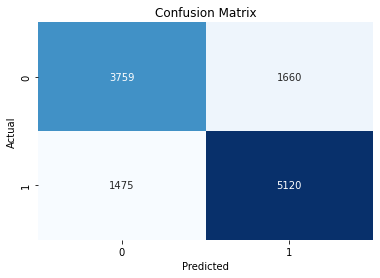

In [1006]:
threshold = 0.50
y_pred_labels = (y_pred > threshold).astype(int)
confusion = confusion_matrix(y_test, y_pred_labels)
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [997]:
from sklearn.metrics import confusion_matrix

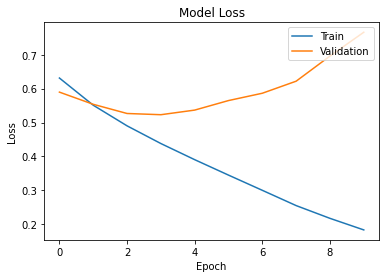

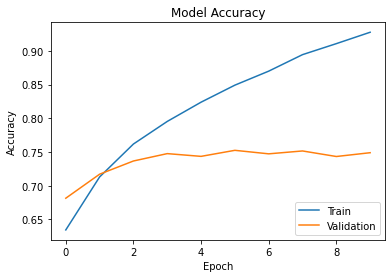

In [1007]:
import matplotlib.pyplot as plt

# Assuming you have trained your model and stored the training history in model_history

# Plot training & validation loss values
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Plot training & validation accuracy values
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

In [1015]:
from sklearn.model_selection import StratifiedKFold
from keras.layers import Dense, Dropout, Flatten
import datetime
from keras.layers import GRU
from tensorflow.keras.optimizers import Adam

In [ ]:
# Define the number of folds
num_folds = 5

# Initialize lists to store accuracy and F1 scores for each fold
acc_scores = []
f1_scores = []

# Initialize StratifiedKFold for splitting the data
skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Define your input layer (assuming maxlen is your sequence length)
input_layer = Input(shape=(maxlen,))
sentiment_scores_pos = Input(shape=(maxlen, 128))
sentiment_scores_neg = Input(shape=(maxlen, 128))

# Define embedding layer
embedding_layer = Embedding(vocab_length, 300, weights=[embedding_matrix], input_length=maxlen, trainable=True)(input_layer)

# Add GRU layers with dropout
gru_layer = GRU(256, activation='selu', return_sequences=True)(embedding_layer)
dropout_layer = Dropout(rate=0.4)(gru_layer)

gru_layer = GRU(128, activation='swish', return_sequences=True)(dropout_layer)
dropout_layer = Dropout(rate=0.3)(gru_layer)

gru_layer = GRU(64, activation='elu', return_sequences=True)(dropout_layer)
dropout_layer = Dropout(rate=0.4)(gru_layer)

gru_layer = GRU(128, activation='swish', return_sequences=True)(dropout_layer)
dropout_layer = Dropout(rate=0.3)(gru_layer)

attention_layer = SentAwareAttention()([gru_layer, sentiment_scores_pos,
                               sentiment_scores_neg, embedding_layer])

a, weighted_sum = attention_layer


# Flatten the output and pass it through a Dense layer with sigmoid activation for binary classification
#flatten_layer = Flatten()(dropout_layer)
output_layer = Dense(1, activation='sigmoid')(weighted_sum)

# Create the model
model = Model(inputs=[input_layer, sentiment_scores_pos, sentiment_scores_neg], outputs=output_layer)
print(model.summary())
# Compile model
learning_rate = 0.001
optimizer = Adam(lr=learning_rate)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Loop over each fold
for fold, (train_index, val_index) in enumerate(skf.split(X_train_text_padded, y_train)):
    X_train_text_fold, X_val_text_fold = X_train_text_padded[train_index], X_train_text_padded[val_index]
    X_train_pos_scores_fold, X_val_pos_scores_fold = X_train_pos_scores_reshaped[train_index], X_train_pos_scores_reshaped[val_index]
    X_train_neg_scores_fold, X_val_neg_scores_fold = X_train_neg_scores_reshaped[train_index], X_train_neg_scores_reshaped[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    # Define a callback to perform early stopping if the model is no longer improving
    stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)

    # Model training
    model_history = model.fit([X_train_text_fold, X_train_pos_scores_fold, X_train_neg_scores_fold], y_train_fold, 
                              batch_size=16, epochs=50, verbose=1, validation_split=0.2, callbacks=[stop_early])
    
    # Evaluate the model on the validation set
    val_preds = model.predict(X_val_text_fold, X_val_pos_scores_fold, X_val_neg_scores_fold)
    val_preds = (val_preds > 0.5).astype(int)
    
    # Calculate accuracy and F1 score
    acc = accuracy_score(y_val_fold, val_preds)
    f1 = f1_score(y_val_fold, val_preds)
    
    # Append the scores to the lists
    acc_scores.append(acc)
    f1_scores.append(f1)

    print(f"Fold {fold+1}: Accuracy = {acc:.4f}, F1 Score = {f1:.4f}")

# Calculate the mean and standard deviation of accuracy and F1 scores across folds
mean_acc = np.mean(acc_scores)
mean_f1 = np.mean(f1_scores)

# Print the cross-validation results
print(f"Mean Accuracy: {mean_acc:.4f}")
print(f"Mean F1 Score: {mean_f1:.4f}")

Model: "model_66"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_434 (InputLayer)         [(None, 38)]         0           []                               
                                                                                                  
 embedding_243 (Embedding)      (None, 38, 300)      11515800    ['input_434[0][0]']              
                                                                                                  
 gru_230 (GRU)                  (None, 38, 256)      428544      ['embedding_243[0][0]']          
                                                                                                  
 dropout_36 (Dropout)           (None, 38, 256)      0           ['gru_230[0][0]']                
                                                                                           

None
Epoch 1/50


C:\Users\niamh\anaconda3\lib\site-packages\tensorflow\python\data\ops\structured_function.py:256: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


  43/1923 [..............................] - ETA: 33:27 - loss: 0.6871 - accuracy: 0.5567

# Comparative evaluation of Emoji-Containing Optimised GRU model

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score

# Define the number of folds
num_folds = 5

# Initialize lists to store accuracy and F1 scores for each fold
acc_scores = []
f1_scores = []

# Initialize StratifiedKFold for splitting the data
skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Define your input layer (assuming maxlen is your sequence length)
input_layer = Input(shape=(maxlen,))

# Define embedding layer
embedding_layer = Embedding(vocab_length, 300, weights=[embedding_matrix], input_length=maxlen, trainable=True)(input_layer)

# Add GRU layers with dropout
gru_layer = GRU(384, activation='selu', return_sequences=True)(embedding_layer)
dropout_layer = Dropout(rate=0.2)(gru_layer)

gru_layer = GRU(512, activation='elu', return_sequences=True)(dropout_layer)
dropout_layer = Dropout(rate=0.4)(gru_layer)

gru_layer = GRU(64, activation='selu', return_sequences=True)(dropout_layer)
dropout_layer = Dropout(rate=0.0)(gru_layer)

gru_layer = GRU(128, activation='relu', return_sequences=True)(dropout_layer)
dropout_layer = Dropout(rate=0.0)(gru_layer)

# Flatten the output and pass it through a Dense layer with sigmoid activation for binary classification
flatten_layer = Flatten()(dropout_layer)
output_layer = Dense(1, activation='sigmoid')(flatten_layer)

# Create the model
model = Model(inputs=input_layer, outputs=output_layer)
print(model.summary())
# Compile model
learning_rate = 0.001
optimizer = Adam(lr=learning_rate)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Loop over each fold
for fold, (train_index, val_index) in enumerate(skf.split(X_train_padded, y_train)):
    X_train_fold, X_val_fold = X_train_padded[train_index], X_train_padded[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    # Define a callback to perform early stopping if the model is no longer improving
    stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)

    # Model training
    model_history = model.fit(X_train_fold, y_train_fold, batch_size=16, epochs=50, verbose=1, validation_split=0.2, 
                              callbacks=[stop_early])

    # Evaluate the model on the validation set
    val_preds = model.predict(X_val_fold)
    val_preds = (val_preds > 0.5).astype(int)
    
    # Calculate accuracy and F1 score
    acc = accuracy_score(y_val_fold, val_preds)
    f1 = f1_score(y_val_fold, val_preds)
    
    # Append the scores to the lists
    acc_scores.append(acc)
    f1_scores.append(f1)

    print(f"Fold {fold+1}: Accuracy = {acc:.4f}, F1 Score = {f1:.4f}")

# Calculate the mean and standard deviation of accuracy and F1 scores across folds
mean_acc = np.mean(acc_scores)
mean_f1 = np.mean(f1_scores)

# Print the cross-validation results
print(f"Mean Accuracy: {mean_acc:.4f}")
print(f"Mean F1 Score: {mean_f1:.4f}")